In [1]:
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [2]:
import torch
import torch.nn as nn
from torch import fx
from torch.nn import functional as F

In [3]:
from tvm import te

In [4]:
A = te.placeholder((128, 128), name="A", dtype="float32")
B = te.placeholder((128, 128), name="B", dtype="float32")

In [9]:
def te_matmul(A: te.Tensor, B: te.Tensor) -> te.Tensor:
    assert A.shape[1] == B.shape[0]
    n = A.shape[0]
    m = B.shape[1]
    k = te.reduce_axis((0, A.shape[1]), name="k")
    return te.compute((n, m), lambda i, j: te.sum(A[i, k] * B[k, j], axis=k), name="matmul")

In [10]:
C = te_matmul(A, B)

In [14]:
te.create_prim_func([A, B, C]).show()

In [15]:
def te_relu(A: te.Tensor) -> te.Tensor:
    return te.compute(A.shape, lambda *i: te.max(A(*i), 0), name="relu")

In [16]:
X1 = te.placeholder((10,), name="X1", dtype="float32")
Y1 = te_relu(X1)
te.create_prim_func([X1, Y1]).show()

In [17]:
X2 = te.placeholder((10, 20), name="X2", dtype="float32")
Y2 = te_relu(X2)
te.create_prim_func([X2, Y2]).show()

In [18]:
C = te_matmul(A, B)
D = te_relu(C)

In [19]:
te.create_prim_func([A, B, D]).show()

In [20]:
te.create_prim_func([A, B, C, D]).show()

In [21]:
A = relax.Var("A", relax.TensorStructInfo((128, 128), "float32"))
B = relax.Var("B", relax.TensorStructInfo((128, 128), "float32"))

In [24]:
bb = relax.BlockBuilder()

with bb.function("main"):
    with bb.dataflow():
        C = bb.emit_te(te_matmul, A, B)
        D = bb.emit_te(te_relu, C)
        R = bb.emit_output(D)
    bb.emit_func_output(R, params=[A, B])

MyModule = bb.get()
MyModule.show()

In [27]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.weight = nn.Parameter(torch.randn(128, 128))

    def forward(self, x):
        x = torch.matmul(x, self.weight)
        x = torch.relu(x)
        return x

In [29]:
model = MyModel()
fx_module = fx.symbolic_trace(model)
type(fx_module)

torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl

In [32]:
fx_module.graph.print_tabular()

opcode         name    target                                                     args         kwargs
-------------  ------  ---------------------------------------------------------  -----------  --------
placeholder    x       x                                                          ()           {}
get_attr       weight  weight                                                     ()           {}
call_function  matmul  <built-in method matmul of type object at 0x7f154e0e1480>  (x, weight)  {}
call_function  relu    <built-in method relu of type object at 0x7f154e0e1480>    (matmul,)    {}
output         output  output                                                     (relu,)      {}


In [33]:
def map_param(param: nn.Parameter):
    return relax.const(
        param.data.cpu().numpy(), relax.TensorStructInfo(param.data.shape, "float32")
    )

def fetch_attr(fx_mod, target: str):
    """Helper function to fetch an attr"""
    target_atoms = target.split('.')
    attr_itr = fx_mod
    for i, atom in enumerate(target_atoms):
        if not hasattr(attr_itr, atom):
            raise RuntimeError(f"Node referenced nonexistant target {'.'.join(target_atoms[:i])}")
        attr_itr = getattr(attr_itr, atom)
    return attr_itr

def from_fx(fx_mod, input_shapes, call_function_map, call_module_map):
    input_index = 0
    node_map = {}
    named_modules = dict(fx_mod.named_modules())

    bb = relax.BlockBuilder()

    fn_inputs = []
    fn_output = None
    with bb.function("main"):
        with bb.dataflow():
            for node in fx_mod.graph.nodes:
                if node.op == "placeholder":
                    # create input placeholder
                    shape = input_shapes[input_index]
                    input_index += 1
                    input_var = relax.Var(
                        node.target, relax.TensorStructInfo(shape, "float32")
                    )
                    fn_inputs.append(input_var)
                    node_map[node] = input_var
                elif node.op == "get_attr":
                    node_map[node] = map_param(fetch_attr(fx_mod, node.target))
                elif node.op == "call_function":
                    node_map[node] = call_function_map[node.target](bb, node_map, node)
                elif node.op == "call_module":
                    named_module = named_modules[node.target]
                    node_map[node] = call_module_map[type(named_module)](bb, node_map, node, named_module)
                elif node.op == "output":
                    output = node_map[node.args[0]]
                    assert fn_output is None
                    fn_output = bb.emit_output(output)
        # output and finalize the function
        bb.emit_func_output(output, fn_inputs)
    return bb.get()

In [34]:
def map_matmul(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    B = node_map[node.args[1]]
    return bb.emit_te(te_matmul, A, B)

def map_relu(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    return bb.emit_te(te_relu, A)

MyModule = from_fx(
    fx_module,
    input_shapes = [(1, 128)],
    call_function_map = {
      torch.matmul: map_matmul,
      torch.relu: map_relu,
    },
    call_module_map={},
)

MyModule.show()

In [52]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

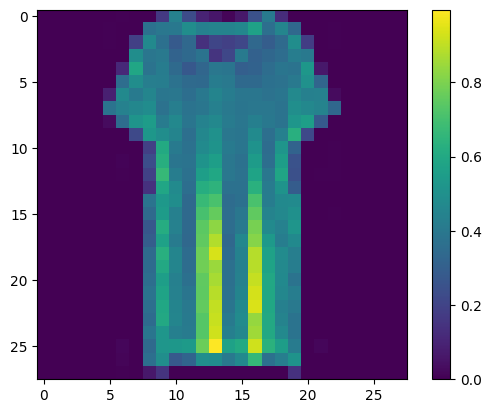

Class: Dress


In [53]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [44]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear0 = nn.Linear(784, 128, bias=True)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(128, 10, bias=True)

    def forward(self, x):
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        return x

In [54]:
import pickle as pkl

mlp_model = MLP()

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
mlp_model.linear0.weight.data = torch.from_numpy(mlp_params["w0"])
mlp_model.linear0.bias.data = torch.from_numpy(mlp_params["b0"])
mlp_model.linear1.weight.data = torch.from_numpy(mlp_params["w1"])
mlp_model.linear1.bias.data = torch.from_numpy(mlp_params["b1"])

In [55]:
torch_res = mlp_model(torch.from_numpy(img.reshape(1, 784)))

pred_kind = np.argmax(torch_res.detach().numpy(), axis=1)
print("Torch Prediction:", class_names[pred_kind[0]])

Torch Prediction: Dress


In [58]:
trace_mod = fx.symbolic_trace(mlp_model)

In [60]:
trace_mod.graph.print_tabular()

opcode       name     target    args        kwargs
-----------  -------  --------  ----------  --------
placeholder  x        x         ()          {}
call_module  linear0  linear0   (x,)        {}
call_module  relu     relu      (linear0,)  {}
call_module  linear1  linear1   (relu,)     {}
output       output   output    (linear1,)  {}


In [56]:
from tvm import topi


def map_nn_linear(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias)
    y = bb.emit_te(topi.nn.dense, x, w)
    return bb.emit_te(topi.add, y, b)

def map_nn_relu(bb, node_map, node, nn_mod):
    return map_relu(bb, node_map, node)


MLPModule = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes = [(1, 784)],
    call_function_map={
    },
    call_module_map={
        torch.nn.Linear: map_nn_linear,
        torch.nn.ReLU: map_nn_relu,
    },
)

MLPModule.show()